## Table of Contents

* Data Set
* Defining a Baseline Model
* Introduction to Deep Neural Networks
    * Introducing Keras API
    * First Keras Model
* What Is a Word Embedding?
     * One-Hot Encoding
     * Word Embeddings
     * Keras Embedding Layer
* Convolutional Neural Networks (CNN)
*  Hyperparameters Optimization

### Importing Packages

import serveral libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import os
# print(os.listdir("../input"))
plt.style.use('ggplot')

Extract the folder into a data folder and go ahead and load the data with Pandas:

This code defines a dictionary of file paths for different datasets and reads them into pandas dataframes. Each dataset contains a sentence column and a label column, separated by tabs. The code then adds a source column to each dataframe with the name of the dataset it came from, and appends each dataframe to a list.





In [ ]:
filepath_dict = {'yelp':   'yelp.txt',
                 'amazon': 'amazon.txt',
                 'imdb':   'imdb.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source
    df_list.append(df)

In [ ]:
df_list

[                                              sentence  label source
 0                             Wow... Loved this place.      1   yelp
 1                                   Crust is not good.      0   yelp
 2            Not tasty and the texture was just nasty.      0   yelp
 3    Stopped by during the late May bank holiday of...      1   yelp
 4    The selection on the menu was great and so wer...      1   yelp
 ..                                                 ...    ...    ...
 995  I think food should have flavor and texture an...      0   yelp
 996                           Appetite instantly gone.      0   yelp
 997  Overall I was not impressed and would not go b...      0   yelp
 998  The whole experience was underwhelming, and I ...      0   yelp
 999  Then, as if I hadn't wasted enough of my life ...      0   yelp
 
 [1000 rows x 3 columns],
                                               sentence  label  source
 0    So there is no way for me to plug it in here i...      

concat data frame df_list

In [ ]:
df = pd.concat(df_list)
df.iloc[0]

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object

print the first 5 rows

In [ ]:
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


print the last 5 rows

In [ ]:
df.tail()

,sentence,label,source
743,I just got bored watching Jessice Lange take h...,0,imdb
744,"Unfortunately, any virtue in this film's produ...",0,imdb
745,"In a word, it is embarrassing.",0,imdb
746,Exceptionally bad!,0,imdb
747,All in all its an insult to one's intelligence...,0,imdb


Now use the `CountVectorizer` provided by the `scikit-learn` library to vectorize sentences. It takes the words of each sentence and creates a vocabulary of all the unique words in the sentences. This vocabulary can then be used to create a feature vector of the count of the words:

define sentences variable

In [ ]:
sentences = ['Rashmi likes ice cream', 'Rashmi hates chocolate.']

This code performs text vectorization using the CountVectorizer class from scikit-learn. It initializes a CountVectorizer object with a minimum document frequency of 0 and case sensitivity turned off. The object is then fitted to the 'sentences' data and the resulting vocabulary is displayed. This vocabulary consists of the unique words found in the sentences, with a corresponding index assigned to each word.





In [ ]:
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'Rashmi': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

This code performs text vectorization using the CountVectorizer object created earlier, transforming a list of sentences into a sparse matrix representation of word counts, and then converting it to a dense array representation. The resulting array contains an integer count for each word in each sentence.





In [ ]:
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]])

## Defining a Baseline Model

First, you are going to split the data into a training and testing set which will allow you to evaluate the accuracy and see if your model generalizes well. This means whether the model is able to perform well on data it has not seen before. This is a way to see if the model is overfitting.

**Overfitting** is when a model is trained too well on the training data. You want to avoid overfitting, as this would mean that the model mostly just memorized the training data. This would account for a large accuracy with the training data but a low accuracy in the testing data. 

We start by taking the Yelp data set which we extract from our concatenated data set. From there, we take the sentences and labels.

This code block extracts Yelp reviews from a pandas dataframe and splits the data into training and testing sets for machine learning.





In [ ]:
df_yelp = df[df['source'] == 'yelp']
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

Create the feature vectors for each sentence of the training and testing set:

This code block creates a CountVectorizer object and fits it to the training data. It then transforms both the training and testing data into vectorized form using the fitted CountVectorizer object.





In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [ ]:
X_train

<750x1715 sparse matrix of type '<class 'numpy.int64'>'
	with 7369 stored elements in Compressed Sparse Row format>

`CountVectorizer` performs tokenization which separates the sentences into a set of **tokens**. It additionally removes punctuation and special characters and can apply other preprocessing to each word. If you want, you can use a custom tokenizer from the NLTK library with the CountVectorizer or use any number of the customizations which you can explore to improve the performance of your model.

The classification model we are going to use is the logistic regression which is a simple yet powerful linear model that is mathematically speaking in fact a form of regression between 0 and 1 based on the input feature vector. By specifying a cutoff value (by default 0.5), the regression model is used for classification. 

This code block creates a LogisticRegression classifier and fits it to the training data. It then evaluates the accuracy of the classifier on the testing data and prints the result.





In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.796


You can see that the logistic regression reached an impressive 79.6%, but let’s have a look how this model performs on the other data sets that we have. In this script, we perform and evaluate the whole process for each data set that we have:

This code block performs sentiment analysis on text data from different sources using a LogisticRegression classifier. It loops through the unique sources in a pandas dataframe and selects the corresponding rows. Then, it splits the data into training and testing sets, vectorizes the text using CountVectorizer, trains a LogisticRegression classifier, and evaluates its accuracy on the testing data. Finally, it prints the accuracy score for each data source.





In [ ]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


Great! You can see that this fairly simple model achieves a fairly good accuracy.

## Introduction to Deep Neural Networks
**Neural networks**, or sometimes called **artificial neural network (ANN)** or**feedforward neural network**, are computational networks which were vaguely inspired by the neural networks in the human brain. They consist of neurons (also called nodes) which are connected like in the graph below.





You start by having a layer of input neurons where you feed in your feature vectors and the values are then feeded forward to a hidden layer. At each connection, you are feeding the value forward, while the value is multiplied by a weight and a bias is added to the value. This happens at every connection and at the end you reach an output layer with one or more output nodes.

If you want to have a binary classification you can use one node, but if you have multiple categories you should use multiple nodes for each category:

### Introducing Keras

Keras is a deep learning and neural networks API by François Chollet which is capable of running on top of Tensorflow (Google), Theano or CNTK (Microsoft). To quote the wonderful book by François Chollet, Deep Learning with Python:

    Keras is a model-level library, providing high-level building blocks for developing deep-learning models. It doesn’t handle low-level operations such as tensor manipulation and differentiation. Instead, it relies on a specialized, well-optimized tensor library to do so, serving as the backend engine of Keras (Source)

It is a great way to start experimenting with neural networks without having to implement every layer and piece on your own. For example Tensorflow is a great machine learning library, but you have to implement a lot of boilerplate code to have a model running.

### First Keras Model

Keras supports two main types of models. You have the Sequential model API and the functional API which can do everything of the Sequential model but it can be also used for advanced models with complex network architectures.

The Sequential model is a linear stack of layers, where you can use the large variety of available layers in Keras. The most common layer is the Dense layer which is your regular densely connected neural network layer with all the weights and biases that you are already familiar with.

Before we build our model, we need to know the input dimension of our feature vectors. This happens only in the first layer since the following layers can do automatic shape inference. In order to build the Sequential model, you can add layers one by one in order

This code block creates a neural network model using the Keras Sequential API. The model has an input dimension equal to the number of features in the training data. It has a single hidden layer with 10 neurons and a ReLU activation function, and a single output layer with a sigmoid activation function.





In [ ]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This code block compiles the neural network model by specifying the loss function, optimizer, and evaluation metrics to be used during training. It then prints a summary of the model architecture.





In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                25090     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 25,101
Trainable params: 25,101
Non-trainable params: 0
_________________________________________________________________


This code block trains the neural network model using the fit() method with the training data. The model is trained for 100 epochs with a batch size of 10. The validation data is used to evaluate the model's performance after each epoch, and the training progress is displayed using the verbose parameter. The training history is stored in the 'history' variable.





In [ ]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/100
57/57 [==============================] - 14s 145ms/step - loss: 0.6948 - accuracy: 0.5775 - val_loss: 0.6819 - val_accuracy: 0.6043
Epoch 2/100
57/57 [==============================] - 6s 107ms/step - loss: 0.6263 - accuracy: 0.8200 - val_loss: 0.6689 - val_accuracy: 0.6684
Epoch 3/100
57/57 [==============================] - 4s 66ms/step - loss: 0.5452 - accuracy: 0.9037 - val_loss: 0.6414 - val_accuracy: 0.7059
Epoch 4/100
57/57 [==============================] - 1s 26ms/step - loss: 0.4552 - accuracy: 0.9483 - val_loss: 0.5949 - val_accuracy: 0.7112
Epoch 5/100
57/57 [==============================] - 2s 29ms/step - loss: 0.3731 - accuracy: 0.9661 - val_loss: 0.5715 - val_accuracy: 0.7273
Epoch 6/100
57/57 [==============================] - 3s 45ms/step - loss: 0.3045 - accuracy: 0.9804 - val_loss: 0.5479 - val_accuracy: 0.7647
Epoch 7/100
57/57 [==============================] - 2s 44ms/step - loss: 0.2507 - accuracy: 0.9840 - val_loss: 0.5527 - val_accuracy: 0.7594
Epo

This code block evaluates the trained neural network model on both the training and testing data, and prints the accuracy score for each. The evaluate() method is used to calculate the loss and accuracy scores, with the verbose parameter set to False to suppress output during evaluation.





In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 1.0000
Testing Accuracy:  0.7754


This code block defines a function named plot_history() that takes a history object as input. It extracts the training and validation accuracy and loss values from the history object, and plots them on separate subplots using Matplotlib. The resulting plot shows the training and validation accuracy and loss as a function of the number of epochs.





In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

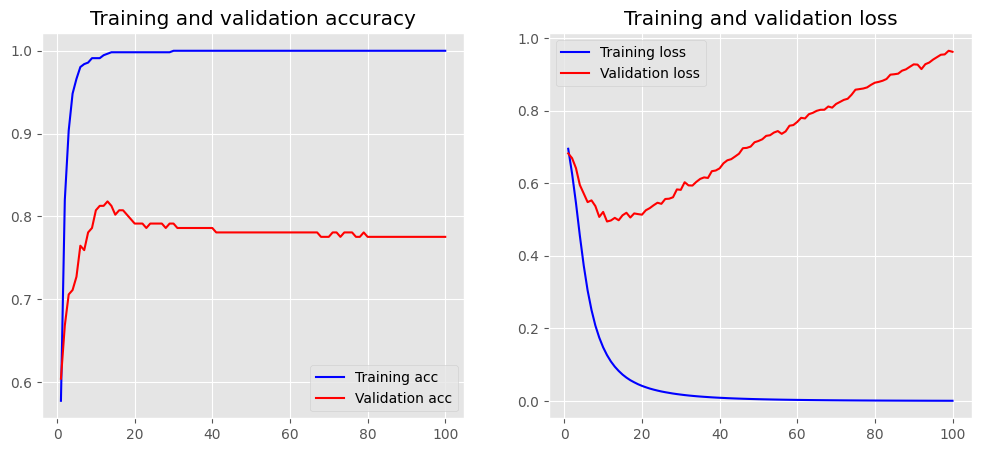

In [ ]:
plot_history(history)

## What Is a Word Embedding?

Text is considered a form of sequence data similar to time series data that you would have in weather data or financial data. Now you will see how to represent each word as vectors. There are various ways to vectorize text, such as:

* Words represented by each word as a vector
* Characters represented by each character as a vector
* N-grams of words/characters represented as a vector (N-grams are overlapping groups of multiple succeeding words/characters in the text)

Here, you’ll see how to deal with representing words as vectors which is the common way to use text in neural networks. Two possible ways to represent a word as a vector are one-hot encoding and word embeddings.

**One-Hot Encoding**

The first way to represent a word as a vector is by creating a so-called one-hot encoding, which is simply done by taking a vector of the length of the vocabulary with an entry for each word in the corpus.

In this way, you have for each word, given it has a spot in the vocabulary, a vector with zeros everywhere except for the corresponding spot for the word which is set to one.

define cities variable

In [ ]:
cities = ['London', 'Berlin', 'Berlin', 'New York', 'London']
cities

['London', 'Berlin', 'Berlin', 'New York', 'London']


`LabelEncoder` to encode the list of cities into categorical integer values

This code block creates a LabelEncoder object named 'encoder' and applies it to the 'cities' array by calling the fit_transform() method. The resulting 'city_labels' variable contains the encoded labels for each city in the 'cities' array.





In [ ]:
encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)
city_labels

array([1, 0, 0, 2, 1])

OneHotEncoder expects each categorical value to be in a separate row, so you’ll need to reshape the array, then you can apply the encoder:

This code block creates a OneHotEncoder object named 'encoder' and applies it to the 'city_labels' variable. The reshape() method is called to convert the 1D 'city_labels' array into a 2D array with a single column, which is required by the OneHotEncoder. The fit_transform() method is then called to generate a one-hot encoded matrix where each row represents a city and each column represents a unique label. The resulting matrix is returned.





In [ ]:
encoder = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape((5, 1))
encoder.fit_transform(city_labels)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

**Word Embeddings**

This method represents words as dense word vectors (also called word embeddings) which are trained unlike the one-hot encoding which are hardcoded. This means that the word embeddings collect more information into fewer dimensions.

Note that the word embeddings do not understand the text as a human would, but they rather map the statistical structure of the language used in the corpus. Their aim is to map semantic meaning into a geometric space. This geometric space is then called the embedding space.

Now you need to tokenize the data into a format that can be used by the word embeddings. Keras offers a couple of convenience methods for text preprocessing and sequence preprocessing which you can employ to prepare your text.

You can start by using the Tokenizer utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. You can add the parameter num_words, which is responsible for setting the size of the vocabulary. The most common num_words words will be then kept.

This code block creates a tokenizer object named 'tokenizer' and applies it to the 'sentences_train' variable. The fit_on_texts() method is called to create a vocabulary from the training set of sentences. The texts_to_sequences() method is then called on both the training and testing sets to convert the sentences into sequences of integers. The 'vocab_size' variable is set to the length of the tokenizer's word index plus 1 to account for the reserved index 0. Finally, the original sentence at index 2 of the training set and its corresponding integer sequence are printed to verify the transformation.





In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

I am a fan of his ... This movie sucked really bad.  
[7, 150, 2, 932, 4, 49, 6, 11, 563, 45, 30]


In [ ]:
for word in ['the', 'all','fan']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 27
fan: 932


** pad sequences with Keras**

This code block is used for padding the sequences of text data. It sets a maximum length of the sequences to 100, and pads the sequences with zeros (post-padding) if they are shorter than the maximum length. X_train and X_test are the padded sequences that are generated by using the pad_sequences() function on the tokenized sentences. Finally, it prints the first 100 elements of the first training sequence after padding.





In [ ]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[170 116 390  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


### Keras Embedding Layer

Now you can use the Embedding Layer of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding. You will need the following parameters:
* **input_dim**: the size of the vocabulary
* **output_dim**: the size of the dense vector
* **input_length**: the length of the sequence

With the Embedding layer we have now a couple of options. One way would be to take the output of the embedding layer and plug it into a Dense layer. In order to do this you have to add a Flatten layer in between that prepares the sequential input for the Dense layer:

This code block initializes a neural network model with an embedding layer, a flatten layer, two dense layers, and an output layer. The embedding layer takes in the tokenized input data with a vocabulary size of vocab_size and an embedding dimension of embedding_dim. The flatten layer flattens the output from the embedding layer. The two dense layers have 10 and 1 nodes, respectively, with the relu and sigmoid activation functions. The model is then compiled with the Adam optimizer, binary crossentropy loss function, and accuracy metric. Finally, a summary of the model architecture is printed.





In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           128750    
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                50010     
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 178,771
Trainable params: 178,771
Non-trainable params: 0
_________________________________________________________________


This code block defines, compiles, trains, and evaluates a neural network model for binary classification. The neural network has an embedding layer, a flatten layer, a dense layer with 10 units, and an output layer with one unit and sigmoid activation function. It is trained for 20 epochs with a batch size of 10, and the training and testing accuracy are printed, along with a plot of the training and validation accuracy and loss.





Epoch 1/20
57/57 [==============================] - 10s 148ms/step - loss: 0.6964 - accuracy: 0.4920 - val_loss: 0.6933 - val_accuracy: 0.4866
Epoch 2/20
57/57 [==============================] - 6s 96ms/step - loss: 0.6897 - accuracy: 0.5312 - val_loss: 0.6972 - val_accuracy: 0.4866
Epoch 3/20
57/57 [==============================] - 3s 59ms/step - loss: 0.6728 - accuracy: 0.5508 - val_loss: 0.6867 - val_accuracy: 0.4866
Epoch 4/20
57/57 [==============================] - 2s 28ms/step - loss: 0.5726 - accuracy: 0.8128 - val_loss: 0.6573 - val_accuracy: 0.5936
Epoch 5/20
57/57 [==============================] - 2s 39ms/step - loss: 0.2931 - accuracy: 0.9376 - val_loss: 0.6403 - val_accuracy: 0.6417
Epoch 6/20
57/57 [==============================] - 2s 31ms/step - loss: 0.1042 - accuracy: 0.9893 - val_loss: 0.5729 - val_accuracy: 0.7112
Epoch 7/20
57/57 [==============================] - 1s 15ms/step - loss: 0.0421 - accuracy: 0.9964 - val_loss: 0.6045 - val_accuracy: 0.7005
Epoch 8/20


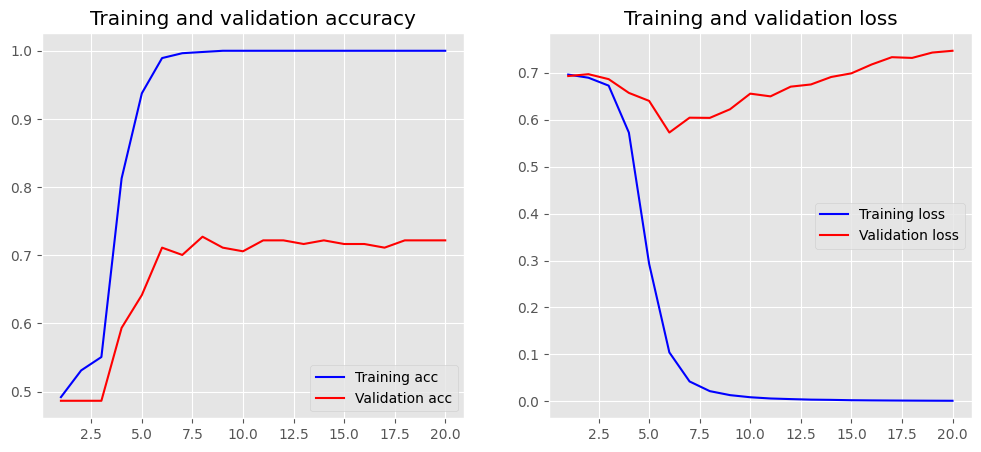

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size. Keras has again its own layer that you can add in the sequential model:

This code block sets up a neural network model with an embedding layer followed by a global max pooling layer, two dense layers with ReLU and sigmoid activations respectively, and the Adam optimizer with binary crossentropy loss. The input dimension, output dimension, and input length are specified in the embedding layer. The model is then compiled and summarized.





In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           128750    
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


This code block creates a neural network model with an embedding layer, a global max pooling layer, two dense layers, and a sigmoid activation function. It trains the model on the training data and evaluates its accuracy on both the training and testing data. Finally, it calls the plot_history() function to visualize the accuracy and loss during training.





Training Accuracy: 1.0000
Testing Accuracy:  0.7487


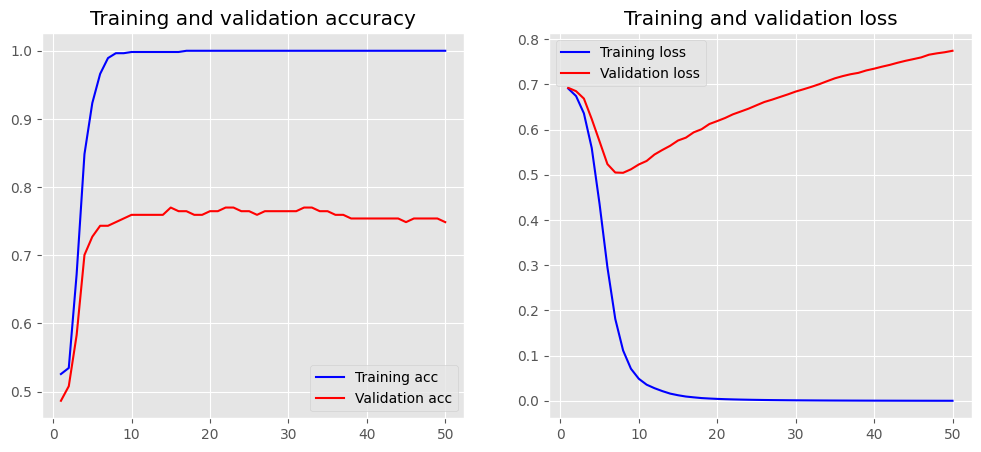

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Convolutional Neural Networks (CNN)

Convolutional neural networks or also called **convnets** are one of the most exciting developments in machine learning in recent years.

They have revolutionized image classification and computer vision by being able to extract features from images and using them in neural networks. The properties that made them useful in image processing makes them also handy for sequence processing. You can imagine a CNN as a specialized neural network that is able to detect specific patterns.

A CNN has hidden layers which are called convolutional layers. When you think of images, a computer has to deal with a two dimensional matrix of numbers and therefore you need some way to detect features in this matrix. These convolutional layers are able to detect edges, corners and other kinds of textures which makes them such a special tool. The convolutional layer consists of multiple filters which are slid across the image and are able to detect specific features.

This code block defines a convolutional neural network for text classification. The network consists of an embedding layer followed by a 1D convolutional layer with 128 filters, a global max pooling layer, two dense layers with 10 and 1 units respectively, and an output layer with a sigmoid activation function. The model is compiled with the Adam optimizer and binary cross-entropy loss, and the summary of the model is printed.





In [ ]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          257500    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 322,929
Trainable params: 322,929
Non-trainable params: 0
________________________________________________

This code block trains a convolutional neural network (CNN) for sentiment analysis using the IMDB dataset. The model has one embedding layer, one convolutional layer, one max-pooling layer, two dense layers, and uses binary cross-entropy loss with Adam optimizer. The accuracy of the model is evaluated on both training and test sets, and the history of the training process is visualized using a plot function.





Training Accuracy: 1.0000
Testing Accuracy:  0.7861


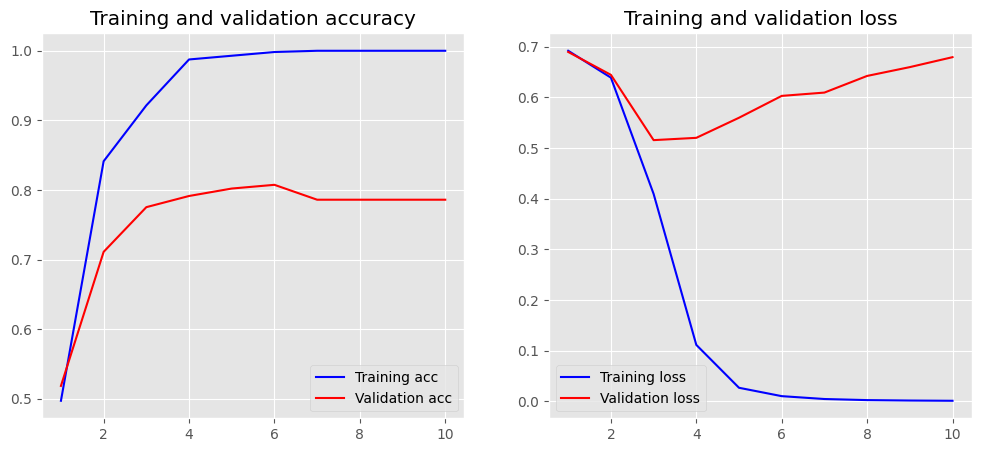

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Hyperparameters Optimization

One crucial steps of deep learning and working with neural networks is hyperparameter optimization.

As you saw in the models that we have used so far, even with simpler ones, you had a large number of parameters to tweak and choose from. Those parameters are called hyperparameters. This is the most time consuming part of machine learning and sadly there are no one-fits-all solutions ready.

One popular method for hyperparameter optimization is **grid search**. What this method does is it takes lists of parameters and it runs the model with each parameter combination that it can find. It is the most thorough way but also the most computationally heavy way to do this. Another common way,**random search**, which you’ll see in action here, simply takes random combinations of parameters.

In order to apply random search with Keras, you will need to use the KerasClassifier which serves as a wrapper for the scikit-learn API. With this wrapper you are able to use the various tools available with scikit-learn like cross-validation. The class that you need is RandomizedSearchCV which implements random search with cross-validation. Cross-validation is a way to validate the model and take the whole data set and separate it into multiple testing and training data sets.

There are various types of cross-validation. One type is the k-fold cross-validation. In this type the data set is partitioned into k equal sized sets where one set is used for testing and the rest of the partitions are used for training. This enables you to run k different runs, where each partition is once used as a testing set. So, the higher k is the more accurate the model evaluation is, but the smaller each testing set is.

This code defines a function create_model() that creates a convolutional neural network for text classification. The function takes the number of filters, kernel size, vocabulary size, embedding dimension, and maximum length of input sequences as input, and returns the compiled model. The architecture of the model includes an embedding layer, a convolutional layer, a global max pooling layer, and two dense layers with ReLU and sigmoid activation functions, respectively. The optimizer used is Adam and the loss function is binary cross-entropy.





In [ ]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

This code block performs a grid search for hyperparameter tuning using a Convolutional Neural Network (CNN) model on three different datasets (yelp, amazon, and imdb). The code uses KerasClassifier, which allows for using Keras models with Scikit-learn's grid search functionality. The code performs tokenization and padding of the input sequences and defines a parameter grid for the hyperparameters of the CNN model. The output includes the best hyperparameters and their corresponding accuracy on the testing set for each dataset.





In [ ]:
# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64],
                      kernel_size=[3, 5],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=3)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
#     prompt = input(f'finished {source}; write to file and proceed? [y/n]')
#     if prompt.lower() not in {'y', 'true', 'yes'}:
#         break
#     with open(output_file, 'w+') as f:
    s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
    output_string = s.format(
        source,
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy)
    print(output_string)
#         f.write(output_string)

Running grid search for data set : amazon
Fitting 4 folds for each of 3 candidates, totalling 12 fits


<ipython-input-34-d351917abe07>:36: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model,


Running amazon data set
Best Accuracy : 0.8186
{'vocab_size': 4603, 'num_filters': 64, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}
Test Accuracy : 0.8326


Running grid search for data set : imdb
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Running imdb data set
Best Accuracy : 0.8152
{'vocab_size': 4603, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}
Test Accuracy : 0.8326


Running grid search for data set : yelp
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Running yelp data set
Best Accuracy : 0.8127
{'vocab_size': 4603, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}
Test Accuracy : 0.8443


